In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore", message="Mean of empty slice", category=RuntimeWarning)

In [3]:
Path='/home/mgander/Atlantic/data/copied_data'

In [4]:
Df0=pd.read_pickle(f'{Path}/TMT/Patients.pkl')
exps=Df0['Experiment']
Df0['type']=[a.split('_')[1] for a in exps]
Df0['Batch']=[a.split('_')[0] for a in exps]

In [5]:
Df1=pd.read_pickle(f'{Path}/TMT/Cell_lines.pkl')
exps=Df1['Experiment']
Df1['type']=[a.split('_')[1] for a in exps]
Df1['Batch']=[a.split('_')[0]+'_CYL' for a in exps]

In [8]:
Df1

,Proteins,Modified sequence,Gene names,Score,Reporter intensity corrected 1,Reporter intensity corrected 2,Reporter intensity corrected 3,Reporter intensity corrected 4,Reporter intensity corrected 5,Reporter intensity corrected 6,Reporter intensity corrected 7,Reporter intensity corrected 8,Reporter intensity corrected 9,Reporter intensity corrected 10,Reporter intensity corrected 11,Experiment,Cancertype,type,Batch
0,H7BZH4;X6R3N0;Q5K4L6-2;Q5K4L6,_ILQCQGFYQLCGVHQEDVIYLALPLYHMSGSLLGIVGCMGIGATV...,SLC27A3,9.4842,18798.0,5998.1,41290.0,54253.0,4757.9,5932.0,19544.0,0.0,8118.0,7662.4,5700.0,Batch9_FP_CYL,Cell_lines,FP,Batch9_CYL
1,E7ESA7;P29474,_GHMFVCGDVTMATNVLQTVQRILATEGDMELDEAGDVIGVLR_,NOS3,11.1650,47052.0,1310000.0,266480.0,232530.0,565110.0,548130.0,160700.0,1191600.0,25721.0,19786.0,0.0,Batch9_FP_CYL,Cell_lines,FP,Batch9_CYL
2,NaN,_DSSPNSSQSHPSMPSALPSCTHHESPILLSLATASAKSIK_,NaN,11.1930,36092.0,17862.0,20081.0,20245.0,6705.6,16126.0,22243.0,1256.3,22763.0,28838.0,27442.0,Batch9_FP_CYL,Cell_lines,FP,Batch9_CYL
3,NaN,_EGLARSQKELFGVSGASHCTVASSGLSALPCSPEQVCVAK_,NaN,11.4810,50867.0,49072.0,47584.0,52495.0,30265.0,58822.0,51891.0,9940.8,22682.0,12176.0,13441.0,Batch9_FP_CYL,Cell_lines,FP,Batch9_CYL
4,Q96HJ5-2;Q96HJ5,_TWIQNSFGMNIASATIALVGTAFLSLNIAVNIQSLR_,MS4A3,12.8650,71965.0,135450.0,40107.0,19264.0,56865.0,86668.0,69808.0,95512.0,23091.0,5921.1,5888.8,Batch9_FP_CYL,Cell_lines,FP,Batch9_CYL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295547,Q9Y6D5,_GSS(ph)LSGTDDGAQEVVK_,ARFGEF2,595.4700,199760.0,308080.0,96969.0,324580.0,117360.0,154540.0,70836.0,9081.9,171110.0,116400.0,102510.0,Batch10_PP_CYL,Cell_lines,PP,Batch10_CYL
295548,Q02952;Q02952-3;Q02952-2,_EDEKGDDVDDPENQNSALADTDASGGLTKES(ph)PDTNGPK_,AKAP12,595.5200,83584.0,386860.0,63349.0,660230.0,30709.0,39625.0,7224.6,0.0,232680.0,260050.0,258840.0,Batch10_PP_CYL,Cell_lines,PP,Batch10_CYL
295549,E7ETY2;Q13428-6;Q13428-7;A0A3B3IS06;H0Y8Y7;Q13...,_AGTATS(ph)PAGSSPAVAGGTQR_,TCOF1,598.7100,286330.0,367990.0,42457.0,83982.0,86452.0,217010.0,87456.0,0.0,124520.0,135100.0,120790.0,Batch10_PP_CYL,Cell_lines,PP,Batch10_CYL
295550,O14745;O14745-2;J3QRP6,_SAS(ph)SDTSEELNSQDSPPK_,SLC9A3R1,603.1000,280880.0,470190.0,339450.0,211230.0,131650.0,286570.0,133210.0,178400.0,232730.0,91584.0,81382.0,Batch10_PP_CYL,Cell_lines,PP,Batch10_CYL


In [7]:
Df=pd.concat([Df0, Df1], ignore_index=True)
Df['Experiment']=Df['Experiment'].astype('category')
exps=sorted(set(Df['Experiment']))

In [8]:
def normalize_and_map_patients_and_CCL(Dfe, D_batch_and_tmt):
    # Normalize with the "local" reference, i.e. the last 3 TMT channels
    # Singularize by Score
    Dfe=Dfe.sort_values('Score')
    Dfe=Dfe.drop_duplicates('Modified sequence')
    Dfe.index=Dfe['Modified sequence']

    prot_type=list(set(Dfe['type']))[0]
    batch=sorted(set(Dfe['Batch']))
    if len(batch)!=1:
        print('Errör')
    else:
        batch=batch[0]
        
    if D_batch_and_tmt[batch]=='nan':
        return(pd.DataFrame())
    
    else:
        D_loc=D_batch_and_tmt[batch].copy()
        for k in list(D_loc.keys()):
            D_loc[k]=prot_type+'_'+D_loc[k]

        # Rename column naming
        cols=Dfe.columns
        new_cols=[]
        tmt_channels=[]
        for c in cols:
            if 'Reporter intensity corrected' in c:
                tmt=int(c.split(' ')[-1])
                entry=D_loc[tmt]
                #print(entry)
                if entry!='nan':
                    new_cols.append(D_loc[tmt]+f'_TMT{tmt}')
                    tmt_channels.append(new_cols[-1])
            else:
                new_cols.append(c)
        Dfe.columns=new_cols


        Dfe=Dfe[tmt_channels]
        Dfe[Dfe==0]=np.NaN

        # Median normalie each TMT channel
        Dfe[tmt_channels]=Dfe[tmt_channels].div(np.nanmedian(Dfe[tmt_channels],0),1)

        # Divide each TMT channel by the reference
        ref_channels=[a for a in Dfe.columns if 'Ref' in a]
        Dfe['Reference']=np.nanmean(Dfe[ref_channels], 1)
        Dfe[tmt_channels]=Dfe[tmt_channels].div(Dfe['Reference'], axis=0)
        del Dfe['Reference']
        return(Dfe)

In [10]:
Df0

,Proteins,Modified sequence,Gene names,Score,Reporter intensity corrected 1,Reporter intensity corrected 2,Reporter intensity corrected 3,Reporter intensity corrected 4,Reporter intensity corrected 5,Reporter intensity corrected 6,Reporter intensity corrected 7,Reporter intensity corrected 8,Reporter intensity corrected 9,Reporter intensity corrected 10,Reporter intensity corrected 11,Experiment,Cancertype,type,Batch
0,B7ZM68;Q6ZNL6;Q6ZNL6-2,_VTGKNRR_,FGD5,0.00,0.00,0.0,1603.40,0.00,0.00,2217.60,0.0,1018.3,3407.8,2420.70,2908.0,Batch62_PP_Chordoma_redo,Chordoma,PP,Batch62
1,NaN,_RKPSFIR_,NaN,0.00,4879.90,10917.0,8056.60,38849.00,7032.80,9509.90,10426.0,13630.0,16925.0,5501.50,4753.6,Batch62_PP_Chordoma_redo,Chordoma,PP,Batch62
2,A0A0G2JIW1;P0DMV8-2;P0DMV9;P0DMV8;V9GZ37;P1114...,_TACERAKR_,HSPA1A;HSPA1B;HSPA8;HSPA2;HSPA6;HSPA7,0.00,2977.50,1191.0,5663.60,534.35,11360.00,7132.30,2374.2,6016.7,0.0,0.00,0.0,Batch62_PP_Chordoma_redo,Chordoma,PP,Batch62
3,B4DJX4;Q9HAU0-8;Q9HAU0;Q9HAU0-2;Q9HAU0-4;Q9HAU...,_TSRASKK_,PLEKHA5,0.00,1246.50,0.0,1636.00,1289.70,7134.00,4019.60,1538.6,4544.0,29957.0,18187.00,18284.0,Batch62_PP_Chordoma_redo,Chordoma,PP,Batch62
4,Q9NUT2-5;Q9NUT2-4;Q9NUT2-3;Q9NUT2-2;Q9NUT2,_TAAPPPKK_,ABCB8,0.00,781.34,1051.4,715.03,0.00,1121.70,1571.00,1774.3,2834.9,0.0,933.09,0.0,Batch62_PP_Chordoma_redo,Chordoma,PP,Batch62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19642282,P13861;P13861-2,_GDSES(ph)EEDEDLEVPVPSR_,PRKAR2A,501.33,24176.00,6954.8,30414.00,68134.00,2672.50,6167.40,102700.0,27574.0,31483.0,71501.00,83757.0,Batch157_PP_MASTER,Sarcoma,PP,Batch157
19642283,A0A3B3ISF0;H0Y9K3;D6R9W6;Q659C4-9;Q659C4;A0A3B...,_LNGPGENVS(ph)EDEAQSSNQR_,LARP1B,501.38,17692.00,2607.1,10333.00,23875.00,0.00,258.17,24310.0,13785.0,43302.0,111830.00,115930.0,Batch157_PP_MASTER,Sarcoma,PP,Batch157
19642284,Q9BXB4,_SFSLASSSNS(ph)PISQR_,OSBPL11,501.47,101160.00,15976.0,61594.00,136900.00,17404.00,4916.30,35886.0,94208.0,486590.0,818010.00,911380.0,Batch157_PP_MASTER,Sarcoma,PP,Batch157
19642285,P40818;P40818-2,_SYSS(ph)PDITQAIQEEEK_,USP8,533.03,25371.00,8217.6,22032.00,70757.00,719.57,4605.80,57072.0,70414.0,40893.0,83244.00,85201.0,Batch157_PP_MASTER,Sarcoma,PP,Batch157


In [9]:
dfp=pd.read_csv('/media/kusterlab/internal_projects/active/TOPAS/WP31/Searches/patient_annotation_231127_PAN_cancer.csv')
dfp['Batch']='Batch'+dfp['Batch Name'].astype('str')

dfp_exps=sorted(set(dfp['Batch']))
D_batch_and_tmt={}
for exp in dfp_exps:
    D_batch_and_tmt[exp]={}
    dfpe=dfp[dfp['Batch']==exp]
    for i in range(len(dfpe)):
        D_batch_and_tmt[exp][dfpe['TMT Channel'].iloc[i]]=exp+'_'+dfpe['Sample name'].iloc[i]
    l=0
    for i in range(9,12):
        if not str(i) in D_batch_and_tmt[exp].keys():
            D_batch_and_tmt[exp][i]=exp+f'_Ref{l}'
            l+=1

FileNotFoundError: [Errno 2] No such file or directory: '/media/kusterlab/internal_projects/active/TOPAS/WP31/Searches/patient_annotation_231127_PAN_cancer.csv'

In [52]:
D_batch_and_tmt[f'Batch104']='nan'
D_batch_and_tmt[f'Batch116']='nan'
D_batch_and_tmt[f'Batch126']='nan'
D_batch_and_tmt[f'Batch12']='nan'
D_batch_and_tmt[f'Batch15']='nan'
D_batch_and_tmt[f'Batch21']='nan'
D_batch_and_tmt[f'Batch22']='nan'
D_batch_and_tmt[f'Batch49']='nan'
D_batch_and_tmt[f'Batch69']='nan'
D_batch_and_tmt[f'Batch70']='nan'
D_batch_and_tmt[f'Batch72']='nan'
D_batch_and_tmt[f'Batch83']='nan'
D_batch_and_tmt[f'Batch84']='nan'
D_batch_and_tmt[f'Batch92']='nan'

D_batch_and_tmt['Batch111'][6]='nan'
D_batch_and_tmt['Batch112'][8]='nan'

In [53]:
# The translator for CYL cell lines
Path0='/media/kusterlab/internal_projects/active/TOPAS/WP31/Searches'
df=pd.read_csv(f'{Path0}/patient_annotation_230922_PAN_cancer_celllines_pdx.csv')
df=df[df['Program']=='CYL'].copy()
df['ccl']=['SW982', 'VAESBJ', 'SKES1', 'RDES', 'SW684', 'HT1080', 'SKLMS1', 'SW827', 'KHOS240S',
         'KHOSNP', 'RD', 'HS729', 'A204', 'G401', 'SYO1', 'MESSA']
df9=df[df['Batch Name']=='CL9'].copy()
df10=df[df['Batch Name']=='CL10'].copy()

D_batch_and_tmt['Batch9_CYL']={df9['TMT Channel'].iloc[i]:'Batch9CYL_'+df9['ccl'].iloc[i] for i in range(len(df9))}
D_batch_and_tmt['Batch9_CYL'][9]='Batch9CYL_Ref0'
D_batch_and_tmt['Batch9_CYL'][10]='Batch9CYL_Ref1'
D_batch_and_tmt['Batch9_CYL'][11]='Batch9CYL_Ref2'
D_batch_and_tmt['Batch10_CYL']={df10['TMT Channel'].iloc[i]:'Batch10CYL_'+df10['ccl'].iloc[i] for i in range(len(df10))}
D_batch_and_tmt['Batch10_CYL'][9]='Batch10CYL_Ref0'
D_batch_and_tmt['Batch10_CYL'][10]='Batch10CYL_Ref1'
D_batch_and_tmt['Batch10_CYL'][11]='Batch10CYL_Ref2'

In [79]:
frames=[]
for i in range(len(exps)):
    print(i)
    exp=exps[i]
    Dfe=Df[Df['Experiment']==exp].copy()
    Dfe=normalize_and_map_patients_and_CCL(Dfe, D_batch_and_tmt)
    frames.append(Dfe)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [80]:
# Combine Full- and Phosphosamples

In [81]:
p_frames=[]
f_frames=[]
for frame in frames:
    if len(frame)>0:
        if frame.columns[0][:2]=='PP':
            p_frames.append(frame)
        else:
            f_frames.append(frame)

In [82]:
def polish_matrix(f_frames):
    f_mods=set()
    exps=[]
    for f in f_frames:
        f['Modified sequence']=f.index
        f_mods=f_mods|set(f['Modified sequence'])
        tmt_channels=[a for a in list(f.columns) if a!='Modified sequence']
        exps.append(tmt_channels)
    f_mods=sorted(f_mods)
    D_mods_f={a:i for i,a in enumerate(f_mods)}
    exps=[a for b in exps for a in b]

    # Combine in a DataFrame
    Mf=np.full((len(f_mods), len(exps)), np.NaN)
    l=0
    for i,f in enumerate(f_frames):
        tmt_channels=[a for a in list(f.columns) if a!='Modified sequence']
        k=len(tmt_channels)
        inds=[D_mods_f[a] for a in f['Modified sequence']]
        Mf[inds, l:l+k]=f[tmt_channels].values
        l=l+k
    Mf=pd.DataFrame(data=Mf, index=f_mods, columns=exps)
    
    cols_kept=sorted([a for a in Mf.columns if a!='FP_nan'])
    Mf=Mf[cols_kept].copy()
    
    batches=[a.split('_')[1] for a in Mf.columns]
    tmts=[a.split('TMT')[1] for a in Mf.columns]
    ccl=[a.split('_')[2] for a in Mf.columns]
    Mf.columns=[f'Patients_{batches[i]}_TMT{tmts[i]}_{ccl[i]}_?_0um_0min' for i in range(len(batches))]
    
    return(Mf)

In [83]:
Mf=polish_matrix(f_frames)
Mf.index=['FP'+a for a in Mf.index]

In [84]:
Mp=polish_matrix(p_frames)
Mp.index=['PP'+a for a in Mp.index]

In [85]:
np.isnan(Mp).sum().sum()/Mp.size

0.8664486631340239

In [86]:
np.isnan(Mf).sum().sum()/Mf.size

0.7469631977328577

In [4]:
# Mf.to_pickle(f'{Path}/TMT/Patients_and_CYL/FP_matrix.pkl')
# Mp.to_pickle(f'{Path}/TMT/Patients_and_CYL/PP_matrix.pkl')

Mf=pd.read_pickle(f'{Path}/TMT/Patients_and_CYL/FP_matrix.pkl')
Mp=pd.read_pickle(f'{Path}/TMT/Patients_and_CYL/PP_matrix.pkl')

In [5]:
Mf.shape

(333706, 1507)

In [6]:
Mp.shape

(240441, 1507)

In [9]:
# Combine them

In [10]:
M=pd.concat([Mf,Mp])

In [11]:
M

,Patients_Batch100_TMT6_H021-ARFSS6-T7-Q1_?_0um_0min,Patients_Batch100_TMT7_H021-BATLDZ-T3-Q1_?_0um_0min,Patients_Batch100_TMT8_H021-HTX8PM-T1-Q1_?_0um_0min,Patients_Batch100_TMT1_H021-SBTRPD-M1-Q1_?_0um_0min,Patients_Batch100_TMT2_H021-T7KGC4-M3-Q1_?_0um_0min,Patients_Batch100_TMT3_H021-W4TA9C-T4-Q1_?_0um_0min,Patients_Batch100_TMT4_H021-XHXA22-M7-Q1_?_0um_0min,Patients_Batch100_TMT5_H021-XXRVJ5-M2-Q1_?_0um_0min,Patients_Batch100_TMT9_Ref0_?_0um_0min,Patients_Batch100_TMT10_Ref1_?_0um_0min,...,Patients_Batch9_TMT4_H021-T2J7Z8-M1_?_0um_0min,Patients_Batch9_TMT5_H021-T3LJ7V-T1_?_0um_0min,Patients_Batch9_TMT6_H021-TDDW-T1_?_0um_0min,Patients_Batch9_TMT7_H021-TPPC3H-M2_?_0um_0min,Patients_Batch9_TMT8_H021-U6JPKP-T1_?_0um_0min,Patients_Batch9_TMT9_Ref0_?_0um_0min,Patients_Batch9_TMT10_Ref1_?_0um_0min,Patients_Batch9_TMT11_Ref2_?_0um_0min,Patients_nan_TMT6_TMT6_?_0um_0min,Patients_nan_TMT8_TMT8_?_0um_0min
FP_(ac)AAAAAAAGDSDSWDADAFSVEDPVRK_,0.921993,0.492107,0.670848,0.538492,0.810292,0.625435,1.395092,0.712317,0.363148,1.390281,...,0.129117,0.041097,0.220039,0.204667,0.206801,0.156529,1.452699,1.390773,0.163108,0.586777
FP_(ac)AAAAAAAGDSDSWDADAFSVEDPVR_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FP_(ac)AAAAAAAPSGGGGGGEEERLEEK_,13.846731,NaN,6.184626,3.382498,5.866537,4.519559,2.324466,2.141472,0.555715,1.231848,...,10.774481,NaN,1.609489,3.599747,4.421153,NaN,1.000000,NaN,1.140348,NaN
FP_(ac)AAAAAAAVGGQQPSQPELPAPGLALDK_,NaN,NaN,NaN,NaN,0.692339,NaN,0.559309,0.414098,NaN,1.068045,...,0.492179,0.289958,0.256142,0.604081,0.265115,0.738365,1.122574,1.139061,1.328619,NaN
FP_(ac)AAAAAAGAASGLPGPVAQGLK_,0.334257,0.718098,0.419428,0.442771,0.251913,0.343737,0.849698,0.286318,0.846313,1.105681,...,0.350497,0.572905,0.325717,0.786419,0.295522,0.918953,0.929053,1.151994,0.732108,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PP_YYWGGQYTWDMM(ox)AK_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PP_YYYPNVRDQKVAK_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PP_YYYS(ph)DNFFDGQR_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.585641,0.732537,3.379764,0.376320,0.528704,1.258184,0.735140,1.006676,NaN,NaN
PP_YYYS(ph)VLRMM(ox)REVEGEK_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
M=M[[a for a in Mf.columns if a.split('_')[1]!='nan'].copy()]

In [13]:
M.to_pickle(f'{Path}/TMT/Patients_and_CYL/M.pkl')

In [14]:
M.head()

,Patients_Batch100_TMT6_H021-ARFSS6-T7-Q1_?_0um_0min,Patients_Batch100_TMT7_H021-BATLDZ-T3-Q1_?_0um_0min,Patients_Batch100_TMT8_H021-HTX8PM-T1-Q1_?_0um_0min,Patients_Batch100_TMT1_H021-SBTRPD-M1-Q1_?_0um_0min,Patients_Batch100_TMT2_H021-T7KGC4-M3-Q1_?_0um_0min,Patients_Batch100_TMT3_H021-W4TA9C-T4-Q1_?_0um_0min,Patients_Batch100_TMT4_H021-XHXA22-M7-Q1_?_0um_0min,Patients_Batch100_TMT5_H021-XXRVJ5-M2-Q1_?_0um_0min,Patients_Batch100_TMT9_Ref0_?_0um_0min,Patients_Batch100_TMT10_Ref1_?_0um_0min,...,Patients_Batch9_TMT2_H021-S971AK-M1_?_0um_0min,Patients_Batch9_TMT3_H021-SEET2F-T1_?_0um_0min,Patients_Batch9_TMT4_H021-T2J7Z8-M1_?_0um_0min,Patients_Batch9_TMT5_H021-T3LJ7V-T1_?_0um_0min,Patients_Batch9_TMT6_H021-TDDW-T1_?_0um_0min,Patients_Batch9_TMT7_H021-TPPC3H-M2_?_0um_0min,Patients_Batch9_TMT8_H021-U6JPKP-T1_?_0um_0min,Patients_Batch9_TMT9_Ref0_?_0um_0min,Patients_Batch9_TMT10_Ref1_?_0um_0min,Patients_Batch9_TMT11_Ref2_?_0um_0min
FP_(ac)AAAAAAAGDSDSWDADAFSVEDPVRK_,0.921993,0.492107,0.670848,0.538492,0.810292,0.625435,1.395092,0.712317,0.363148,1.390281,...,NaN,0.345499,0.129117,0.041097,0.220039,0.204667,0.206801,0.156529,1.452699,1.390773
FP_(ac)AAAAAAAGDSDSWDADAFSVEDPVR_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FP_(ac)AAAAAAAPSGGGGGGEEERLEEK_,13.846731,NaN,6.184626,3.382498,5.866537,4.519559,2.324466,2.141472,0.555715,1.231848,...,NaN,6.015242,10.774481,NaN,1.609489,3.599747,4.421153,NaN,1.000000,NaN
FP_(ac)AAAAAAAVGGQQPSQPELPAPGLALDK_,NaN,NaN,NaN,NaN,0.692339,NaN,0.559309,0.414098,NaN,1.068045,...,NaN,0.325510,0.492179,0.289958,0.256142,0.604081,0.265115,0.738365,1.122574,1.139061
FP_(ac)AAAAAAGAASGLPGPVAQGLK_,0.334257,0.718098,0.419428,0.442771,0.251913,0.343737,0.849698,0.286318,0.846313,1.105681,...,NaN,0.439792,0.350497,0.572905,0.325717,0.786419,0.295522,0.918953,0.929053,1.151994


# Check if the cell lines sum up

The reference consists of G401, KHOSNP, RD(=RD2), and HS729

In [6]:
Mf=pd.read_pickle(f'{Path}/TMT/Patients_and_CYL/FP_matrix.pkl')

In [31]:
vals=np.nanmean(Mf[['FP_'+ a for a in ['Batch10CYL_G401', 'Batch10CYL_KHOSNP', 'Batch10CYL_RD', 'Batch10CYL_HS729']]], 1)

<AxesSubplot:ylabel='Count'>

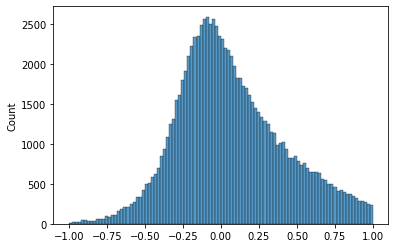

In [37]:
sns.histplot(np.log(vals[np.isfinite(vals)]), bins=np.linspace(-1,1,101))

In [1]:
# And some randoms

In [17]:
rnd=np.random.choice([a for a in Mf.columns if not 'Ref' in a], 4)

In [18]:
vals=np.nanmean(Mf[rnd], 1)

<AxesSubplot:ylabel='Count'>

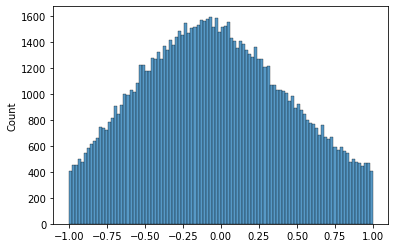

In [19]:
sns.histplot(np.log(vals[np.isfinite(vals)]), bins=np.linspace(-1,1,101))

In [13]:
# So it seems to be ok

In [ ]:
# For phosho

In [4]:
Mf=pd.read_pickle(f'{Path}/TMT/Patients_and_CYL/PP_matrix.pkl')

In [5]:
vals=np.nanmean(Mf[['PP_'+ a for a in ['Batch10CYL_G401', 'Batch10CYL_KHOSNP', 'Batch10CYL_RD', 'Batch10CYL_HS729']]], 1)

<AxesSubplot:ylabel='Count'>

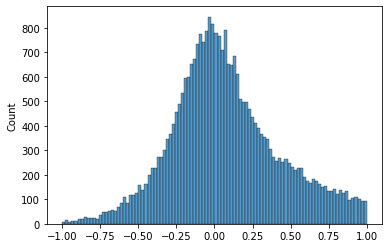

In [6]:
sns.histplot(np.log(vals[np.isfinite(vals)]), bins=np.linspace(-1,1,101))

In [7]:
# And some randoms

In [23]:
rnd=np.random.choice([a for a in Mf.columns if not 'Ref' in a], 4)

In [24]:
vals=np.nanmean(Mf[rnd], 1)

<AxesSubplot:ylabel='Count'>

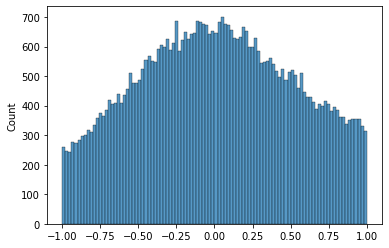

In [25]:
sns.histplot(np.log(vals[np.isfinite(vals)]), bins=np.linspace(-1,1,101))

In [13]:
# So it seems to be ok